In [1]:
!pip install prophet
!pip install keras
!pip install numpy
!pip install pandas
!pip install matplotlib

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
    --------------------------------------- 0.2/13.3 MB 5.8 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/13.3 MB 16.4 MB/s eta 0:00:01
   ------ --------------------------------- 2.1/13.3 MB 4.9 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/13.3 MB 4.9 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/13.3 MB 4.9 MB/s eta 0:00:0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Load data
data_url = 'https://docs.google.com/spreadsheets/d/1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk/export?format=csv&gid=0'
stock_data = pd.read_csv(data_url)
print("Data loaded successfully!")

Data loaded successfully!


In [5]:
# Clean the Price column and convert it to float
stock_data['Cleaned_Price'] = stock_data['Price'].str.extract('(\d+.\d+)').astype(float)

In [6]:
# Ensure the Date column is in the proper datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

In [7]:
# Drop any rows with NaN values which might have been introduced by datetime conversion or price extraction
stock_data.dropna(subset=['Date', 'Cleaned_Price'], inplace=True)

In [8]:
# Calculate Exponential Moving Average (EMA) and Bollinger Bands
stock_data['EMA_20'] = stock_data['Cleaned_Price'].ewm(span=20, adjust=False).mean()
stock_data['SMA_20'] = stock_data['EMA_20']  # Using EMA as the base for Bollinger Bands
stock_data['STD_20'] = stock_data['Cleaned_Price'].rolling(window=20).std()
stock_data['Upper_Band'] = stock_data['SMA_20'] + (stock_data['STD_20'] * 2)
stock_data['Lower_Band'] = stock_data['SMA_20'] - (stock_data['STD_20'] * 2)

In [9]:
# Define trading signals based on Bollinger Bands
def trading_signals(data):
    data['Signal'] = 'Hold'
    data.loc[data['Cleaned_Price'] < data['Lower_Band'], 'Signal'] = 'Buy'
    data.loc[data['Cleaned_Price'] > data['Upper_Band'], 'Signal'] = 'Sell'
    return data

In [10]:
# Apply trading signals
stock_data = trading_signals(stock_data)

In [11]:
# Prepare data for Prophet for forecasting
prophet_data = stock_data[['Date', 'Cleaned_Price']].rename(columns={'Date': 'ds', 'Cleaned_Price': 'y'})
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_data)
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

00:13:20 - cmdstanpy - INFO - Chain [1] start processing
00:13:20 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\MSD\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\MSD\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


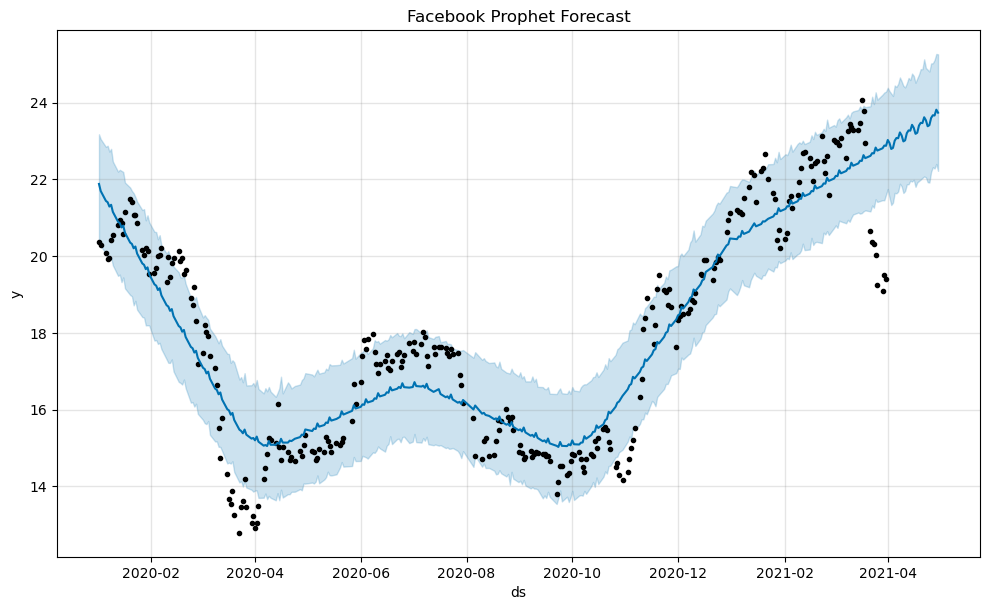

In [12]:
# Plotting Prophet forecast
fig1 = model_prophet.plot(forecast)
plt.title('Facebook Prophet Forecast')
plt.show()

In [13]:
# Data preparation for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Cleaned_Price'].values.reshape(-1,1))
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)
time_step = 10
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

In [14]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.fit(X, y, epochs=100, batch_size=1, verbose=2)  # Fit LSTM model

Epoch 1/100


C:\Users\MSD\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


295/295 - 2s - 7ms/step - loss: 0.0104
Epoch 2/100
295/295 - 1s - 2ms/step - loss: 0.0065
Epoch 3/100
295/295 - 0s - 1ms/step - loss: 0.0046
Epoch 4/100
295/295 - 0s - 1ms/step - loss: 0.0035
Epoch 5/100
295/295 - 0s - 1ms/step - loss: 0.0027
Epoch 6/100
295/295 - 0s - 1ms/step - loss: 0.0025
Epoch 7/100
295/295 - 1s - 2ms/step - loss: 0.0028
Epoch 8/100
295/295 - 0s - 1ms/step - loss: 0.0022
Epoch 9/100
295/295 - 0s - 2ms/step - loss: 0.0019
Epoch 10/100
295/295 - 0s - 1ms/step - loss: 0.0021
Epoch 11/100
295/295 - 0s - 1ms/step - loss: 0.0019
Epoch 12/100
295/295 - 0s - 1ms/step - loss: 0.0020
Epoch 13/100
295/295 - 0s - 1ms/step - loss: 0.0019
Epoch 14/100
295/295 - 0s - 1ms/step - loss: 0.0019
Epoch 15/100
295/295 - 1s - 2ms/step - loss: 0.0018
Epoch 16/100
295/295 - 0s - 1ms/step - loss: 0.0020
Epoch 17/100
295/295 - 0s - 2ms/step - loss: 0.0021
Epoch 18/100
295/295 - 0s - 1ms/step - loss: 0.0018
Epoch 19/100
295/295 - 0s - 1ms/step - loss: 0.0017
Epoch 20/100
295/295 - 0s - 1ms/s

In [15]:
# Prediction using LSTM
train_predict = model_lstm.predict(X)
train_predict = scaler.inverse_transform(train_predict)  # Inverse scaling for plotting

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


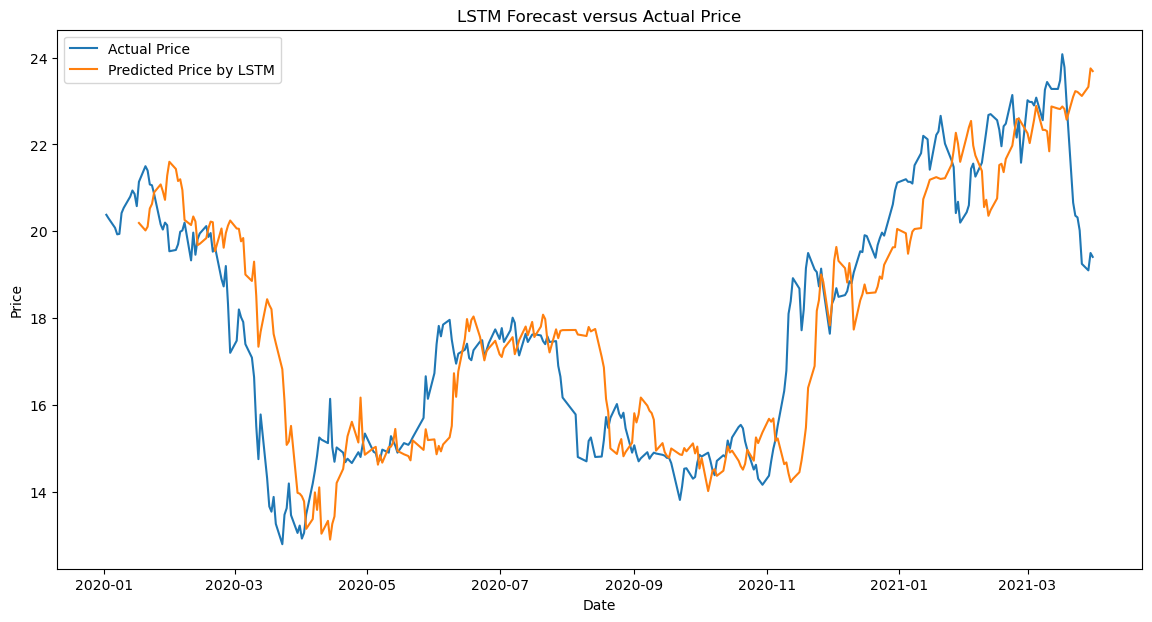

In [16]:
# Plotting results
plt.figure(figsize=(14,7))
plt.plot(stock_data['Date'], stock_data['Cleaned_Price'], label='Actual Price')
plt.plot(stock_data['Date'][:len(train_predict)], train_predict, label='Predicted Price by LSTM')
plt.title('LSTM Forecast versus Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
# Calculate and display MAPE for EMA
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100
ema_mape = calculate_mape(stock_data['Cleaned_Price'][20:], stock_data['EMA_20'][20:])
print(f"EMA MAPE: {ema_mape:.2f}%")

EMA MAPE: 4.49%
